In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian import interpolate, grids, misc, estimation   # modules

def household_guess(a_grid,r,z_grid,gamma,T):
    new_z = np.ones((z_grid.shape[0],1))
    wel = (1 + r) * a_grid[np.newaxis,:] + new_z + T[:,np.newaxis]
    V_prime = (1 + r) * (wel * 0.1) ** (-gamma)
    return V_prime

@het(exogenous = 'Pi',policy = 'a', backward = 'V_prime', backward_init = household_guess)
def household(V_prime_p,a_grid,z_grid,e_grid,r,T,beta,gamma,v,tauc):

    c_prime = (beta * V_prime_p) ** (-1/gamma) # c_prime is the new guess for c_t

    new_grid = (1 + tauc) * c_prime + a_grid[np.newaxis,:] - z_grid[:,np.newaxis] - T[:,np.newaxis]
    wel = (1 + r) * a_grid

    c = interpolate.interpolate_y(new_grid,wel,c_prime)

    a = wel + z_grid[:,np.newaxis] + T[:,np.newaxis] - (1 + tauc) * c
    V_prime = (1 + r) * c ** (-gamma)

    # checks for violations of the condition of minimal assets required and fixes it
    indexes_asset = np.nonzero(a < a_grid[0]) #first dimension: labor grid, second dimension: asset grid
    if indexes_asset[0].size != 0 and indexes_asset[1].size !=0:
        
        a[indexes_asset] = a_grid[0]
        c[indexes_asset] = (wel[indexes_asset[1]] + z_grid[indexes_asset[0]] 
                            + T[indexes_asset[0]] - a[indexes_asset])/(1+tauc)
        V_prime[indexes_asset] = (1 + r) * (c[indexes_asset]) ** (-gamma)
        
    uce = e_grid[:,np.newaxis] * c ** (-gamma)

    return V_prime,a,c,uce

def income(e_grid, w, N, taun):
    z_grid = (1 - taun) * w * N * e_grid
    return z_grid

def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, Pi, a_grid, pi_e

def transfers(pi_e, Div, Transfer, e_grid):
    # hardwired incidence rules are proportional to skill; scale does not matter 
    tax_rule, div_rule = np.ones(e_grid.size), e_grid #np.ones(e_grid.size)
    div = Div / np.sum(pi_e * div_rule) * div_rule
    transfer =  (Transfer) / np.sum(pi_e * tax_rule) * tax_rule 
    T = div + transfer
    return T

hh_inp = household.add_hetinputs([make_grid,transfers,income])

@simple
def firm(Y, w, Z, pi, mu, kappa):
    N = Y / Z
    Div = Y - w * N - mu / (mu - 1) / (2 * kappa) * (1 + pi).apply(np.log) ** 2 * Y
    return Div, N

@simple
def monetary(pi, rstar, phi_pi):
    r = (1 + rstar(-1) + phi_pi * pi(-1)) / (1 + pi) - 1
    return r

@simple
def fiscal(r, Transfer, B, C, N, tauc, taun, w):
    govt_res = Transfer + (1 + r) * B(-1) - tauc * C - taun * w * N - B
    return govt_res

@simple
def mkt_clearing(A, C, Y, B, pi, mu, kappa):
    asset_mkt = A - B
    goods_mkt = Y - C - mu / (mu - 1) / (2 * kappa) * (1 + pi).apply(np.log) ** 2 * Y
    return asset_mkt, goods_mkt

@simple
def nkpc_ss(Z, mu):
    w = Z / mu
    return w

@simple 
def union_ss(w, N, UCE, kw, v, muw, tauc, taun):
    phi = ((1 - taun) * w * N ** (-v) * UCE) / ((1 + tauc) * muw) # our formula
    wnkpc = kw * (phi * N ** (1 + v) - (1 - taun) * w * N * UCE / ((1 + tauc) * muw))
    return wnkpc, phi

@simple 
def auclert_union_ss(w, N, UCE, kw, v, muw, tauc, taun):
    phi = (w * UCE) / (muw * N ** (1 + v)) # our formula
    wnkpc = kw * (phi * N ** (1 + v) - w / muw * UCE)
    
    #vphi = w * UCE / muw / N ** (1 + 1 / v) # their formula
    #wnkpc = vphi * N ** (1 + 1 / frisch) - (1 - tax) * w * UCE / muw
    return wnkpc, phi

blocks_ss = [hh_inp, firm, monetary, fiscal, mkt_clearing, nkpc_ss, union_ss]

hank_ss = create_model(blocks_ss, name = "One-Asset HANK SS")

calibration = {'gamma': 1.0, 'v': 2.0, 'rho_e': 0.966, 'sd_e': 0.5, 'nE': 7,
               'amin': 0, 'amax': 150, 'nA': 500, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005, 'phi_pi': 0.0, 'B': 6.0,
               'kw': 0.0025, 'muw': 1.2, 'N': 1.0, 'tauc': 0.2, 'taun': 0.0}

unknowns_ss = {'beta': 0.986, 'Transfer': -0.03}
targets_ss = {'asset_mkt': 0, 'govt_res': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, backward_tol = 1E-22, solver="hybr")

In [2]:
def household_d(V_prime_p,a_grid,z_grid,e_grid,r,T,beta,gamma,v,tauc):

    c_prime = (beta * V_prime_p) ** (-1/gamma) # c_prime is the new guess for c_t

    new_grid = (1 + tauc) * c_prime + a_grid[np.newaxis,:] - z_grid[:,np.newaxis] - T[:,np.newaxis]
    wel = (1 + r) * a_grid

    c = interpolate.interpolate_y(new_grid,wel,c_prime)

    a = wel + z_grid[:,np.newaxis] + T[:,np.newaxis] - (1 + tauc) * c
    V_prime = (1 + r) * c ** (-gamma)

    # checks for violations of the condition of minimal assets required and fixes it
    indexes_asset = np.nonzero(a < a_grid[0]) #first dimension: labor grid, second dimension: asset grid
    if indexes_asset[0].size != 0 and indexes_asset[1].size !=0:
        
        a[indexes_asset] = a_grid[0]
        c[indexes_asset] = (wel[indexes_asset[1]] + z_grid[indexes_asset[0]] 
                            + T[indexes_asset[0]] - a[indexes_asset])/(1+tauc)
        V_prime[indexes_asset] = (1 + r) * (c[indexes_asset]) ** (-gamma)
        
    uce = e_grid[:,np.newaxis] * c ** (-gamma)

    return V_prime,a,c,uce

In [79]:
z_grid = ss0.internals['household']['z_grid']
e_grid = ss0.internals['household']['e_grid']
a_grid = ss0.internals['household']['a_grid']
pi_e =  ss0.internals['household']['pi_e']
Pi = ss0.internals['household']['Pi']

v = ss0['v']
beta = ss0['beta']
gamma = ss0['gamma']
tauc = ss0['tauc']

In [157]:
c_steady = ss0.internals['household']['c']
r_steady = ss0['r']
Transfer_steady = ss0['Transfer']
Div_steady = ss0['Div']
T_steady = transfers(pi_e,Div_steady,Transfer_steady,e_grid)
w_steady = ss0['w']
N_steady = ss0['N']

V_prime_p = (1+r_steady)*c_steady**(-gamma)
V_prime_p = Pi@V_prime_p

In [104]:
for i in range(1):

    V_prime_p_temp, _, c, _ = household_d(V_prime_p,a_grid,z_grid,e_grid,r_steady,T_steady,beta,gamma,v,tauc)
    V_prime_p = ss0.internals['household']['Pi']@V_prime_p_temp

In [105]:
V_prime_p_old = (1+r_steady)*c_steady**(-gamma)
np.max(np.abs(V_prime_p_temp - V_prime_p_old))

6.960251819343455e-10

In [106]:
np.max(np.abs(c_steady - c))

6.54932019727994e-09

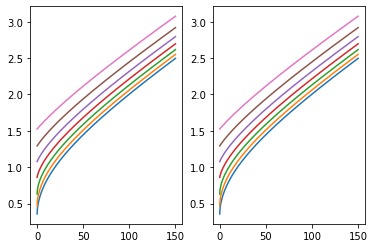

In [15]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(ss0.internals['household']['a_grid'],c_steady.T)
ax[1].plot(ss0.internals['household']['a_grid'],c.T)
plt.show()

In [23]:
@simple
def wage(pi, w):
    piw = (1 + pi) * w / w(-1) - 1
    return piw

@simple
def union(piw,w,N,UCE,kw,phi,v,muw,beta,tauc,taun):
    wnkpc = (kw * (phi * N ** (1+v) - (1 - taun) * w * N * UCE / ((1 + tauc) * muw)) 
             + beta * (1 + piw(+1)).apply(np.log) - (1 + piw).apply(np.log))
    return wnkpc

@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res

blocks = [hh_inp, firm, monetary, fiscal, mkt_clearing, nkpc,wage,union]
hank = create_model(blocks, name = "One-Asset HANK")

ss = hank.steady_state(ss0)

T = 300
exogenous = ['rstar','Transfer', 'Z', 'tauc']
unknowns = ['pi', 'w', 'Y', 'B']
targets = ['nkpc_res', 'asset_mkt', 'wnkpc', 'govt_res']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)

In [26]:
G

<JacobianDict outputs=['pi', 'w', 'Y', 'B', 'A', 'C', 'UCE', 'Div', 'N', 'r', 'govt_res', 'asset_mkt', 'goods_mkt', 'nkpc_res', 'piw', 'wnkpc'], inputs=['rstar', 'Transfer', 'Z', 'tauc']>

In [135]:
rhos = 0.9
drstar = -0.0025 * rhos ** (np.arange(T)[:, np.newaxis])

path_w = w_steady + G['w']['rstar']@drstar
path_r = r_steady + G['r']['rstar']@drstar
path_div = Div_steady + G['Div']['rstar']@drstar
path_n = N_steady + + G['N']['rstar']@drstar

In [221]:
def iterate_household(foo,V_prime_start,Pi,a_grid,w,N,taun,pi_e,e_grid,r,Div,Transfer,beta,gamma,v,tauc,maxit = 1000,tol = 1E-8):
    
    V_prime_p = Pi@V_prime_start
    V_prime_old = V_prime_start
    #_,_,c,_ = foo(V_prime_p,a_grid,z_grid,e_grid,r,T,beta,gamma,v,tauc)
    
    ite = 0
    err = 1
    
    T = transfers(pi_e, Div, Transfer, e_grid)
    z_grid = income(e_grid, w, N, taun)
    
    while ite < maxit and err > tol:
        
        #c_old = np.copy(c)
        V_prime_temp,a,c,uce = foo(V_prime_p,a_grid,z_grid,e_grid,r,T,beta,gamma,v,tauc)
        V_prime_p = Pi@V_prime_temp
        
        ite += 1
        err = np.max(np.abs(V_prime_old - V_prime_temp))
        V_prime_old = V_prime_temp
        
    #print("Iteration ", ite, " out of ", maxit, "\n Difference in policy (sup norm):", err)
    
    return V_prime_temp,a,c,uce 

In [222]:
z_grid = ss0.internals['household']['z_grid']
e_grid = ss0.internals['household']['e_grid']
a_grid = ss0.internals['household']['a_grid']
pi_e =  ss0.internals['household']['pi_e']
Pi = ss0.internals['household']['Pi']

v = ss0['v']
beta = ss0['beta']
gamma = ss0['gamma']
tauc = ss0['tauc']
taun = ss0['taun']
nE = ss0['nE']
nA = ss0['nA']

c_steady = ss0.internals['household']['c']
r_steady = ss0['r']
Transfer_steady = ss0['Transfer']
Div_steady = ss0['Div']
T_steady = transfers(pi_e,Div_steady,Transfer_steady,e_grid)
w_steady = ss0['w']
N_steady = ss0['N']

rhos = 0.9
drstar = -0.0025 * rhos ** (np.arange(T)[:, np.newaxis])

path_w = w_steady + G['w']['rstar']@drstar
path_r = r_steady + G['r']['rstar']@drstar
path_div = Div_steady + G['Div']['rstar']@drstar
path_n = N_steady + G['N']['rstar']@drstar

V_prime_p = (1+r_steady)*c_steady**(-gamma)
all_c = np.zeros((nE,nA,T))

In [229]:
for t in range(299,-1,-1):
    print(t)
    V_prime_p,_,c,_ = iterate_household(household_d,V_prime_p,Pi,a_grid,path_w[t],path_n[t],taun,pi_e,
                            e_grid,path_r[t],path_div[t],Transfer_steady,beta,gamma,v,tauc)
    all_c[:,:,t] = c

299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220
219
218
217
216
215
214
213
212
211
210
209
208
207
206
205
204
203
202
201
200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33

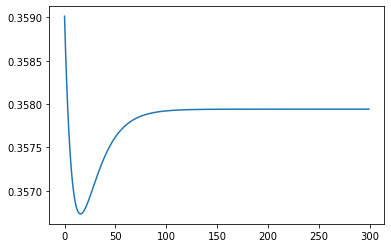

In [230]:
plt.plot(all_c[0,0,:])

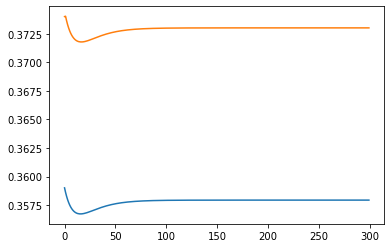

In [233]:
plt.plot(all_c[0,0,:])
plt.plot(all_c[0,7,:])
plt.show()

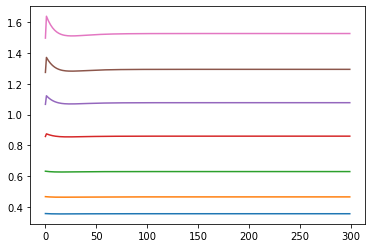

In [235]:
plt.plot(all_c[:,0,:].T)